In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

## Load the data

In [2]:
df = pd.read_csv('../cleaned_data/ISAT.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,0.759710,0.604458,0.595933,0.242258,1.073993,0.336948,0.195283,0.418518,1.067216,0.074403,0.008923,1.34241,1.016593,-1.845348,1.033444,0.147246,1.030312,0.865115
2012-10-18,0.799685,0.635721,0.597431,-0.312385,0.806786,0.206638,0.098052,0.304528,0.918634,0.133079,0.716706,1.34241,1.016593,-1.845348,1.042927,0.261864,1.030312,0.834181
2012-10-19,0.808568,0.664751,0.597431,-0.297827,0.806786,0.206638,0.098052,-0.471880,0.973428,0.288599,1.424489,1.34241,1.016593,-1.845348,1.052410,0.376483,1.030312,0.834181
2012-10-22,0.804127,0.700480,0.607911,-0.381060,1.262253,0.576726,0.392023,0.072030,0.933544,0.944165,-1.406643,1.34241,1.016593,-1.845348,1.080859,0.720337,1.096678,0.926983
2012-10-23,0.821893,0.736209,0.633364,-0.038690,0.946168,0.427620,0.284938,0.419894,0.917644,1.321251,-0.698860,1.34241,1.016593,-1.845348,1.090342,0.834955,1.096678,0.896049


### Plot the Close price - our target

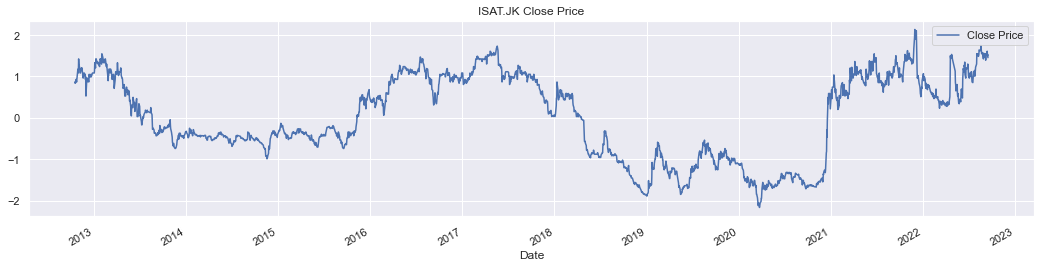

In [3]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('ISAT.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [4]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Understanding Time Series Data

### Decompose time series into Trend, Seasonality, and Random Noise

In [6]:
import statsmodels.api as sm

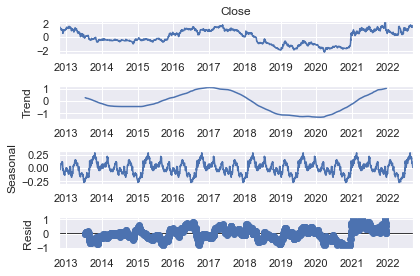

In [7]:
seas_d = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
fig = seas_d.plot()
plt.show()

### ADF Test to check stationarity of the data

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [9]:
test_adf(df['Close'], 'Stock Close Price')

Strong evidence for Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Close Price


In [10]:
"""
The Close price is not stationary. 
Therefore, differencing needs to be performed
"""
test_adf(df['Close'].diff(), 'Stock Close Price - First Difference')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Close Price - First Difference


### Plot ACF (Autocorrelation) and PACF (Partial Autocorrelation)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


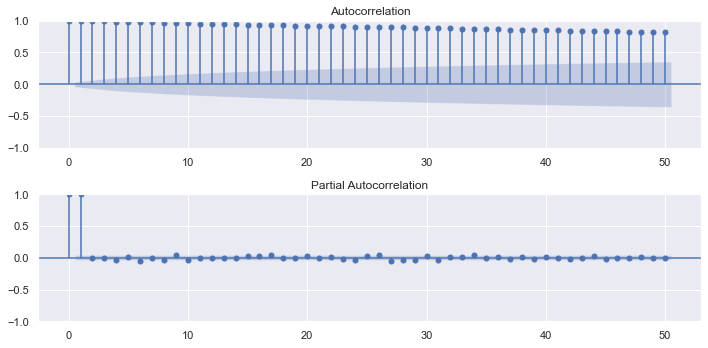

In [11]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

fig = sm.tsa.graphics.plot_acf(df['Close'], lags=50, ax=ax[0])

fig = sm.tsa.graphics.plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

## Build the SARIMAX model

### Use auto_arima to determine the optimal p,d,q orders
We can determine p,d,q orders by using ACF and PACF plots above. However, a stepwise search will enable us to try out more optimal p,d,q orders.

In [12]:
from pmdarima.arima import auto_arima

In [13]:
step_wise_exog = auto_arima(train_labels, exogenous= train_features,
                           start_p=1, start_q=1, 
                           max_p=7, max_q=7, 
                           d=None, D=1, test='adf', max_d=7, seasonal=True, m=5,
                           trace=True, 
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[5] intercept   : AIC=inf, Time=3.55 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=-2021.228, Time=0.27 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=-4529.520, Time=1.14 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=-3242.793, Time=1.19 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=-2019.815, Time=0.13 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=-3991.261, Time=0.54 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=-4674.409, Time=1.55 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=3.92 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=-2028.501, Time=0.98 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=-4677.922, Time=3.12 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=-4532.396, Time=2.36 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=5.27 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=3.41 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=-4678.2

In [14]:
step_wise_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, 0, 5)   Log Likelihood                2347.792
Date:                           Wed, 23 Nov 2022   AIC                          -4681.585
Time:                                   00:32:39   BIC                          -4642.513
Sample:                                        0   HQIC                         -4667.224
                                          - 1967                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9597      0.016     60.632      0.000       0.929       0.991
ar.L2         -0.0210      0.024     -0.885      0.376      -0.068       0.026
ar.L3          0.0083      0.026      0.317      0.751      -0.043       0.059
ar.L4         -0.0441      0.020     -2.252      0.024      -0.083      -0.006
ar.S.L5       -0.6526      0.019    -34.004      0.000      -0.690      -0.615
ar.S.L10      -0.2766      0.019    -14.330      0.000      -0.314      -0.239
sigma2         0.0053   9.48e-05     56.302      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1895.57
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.14
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

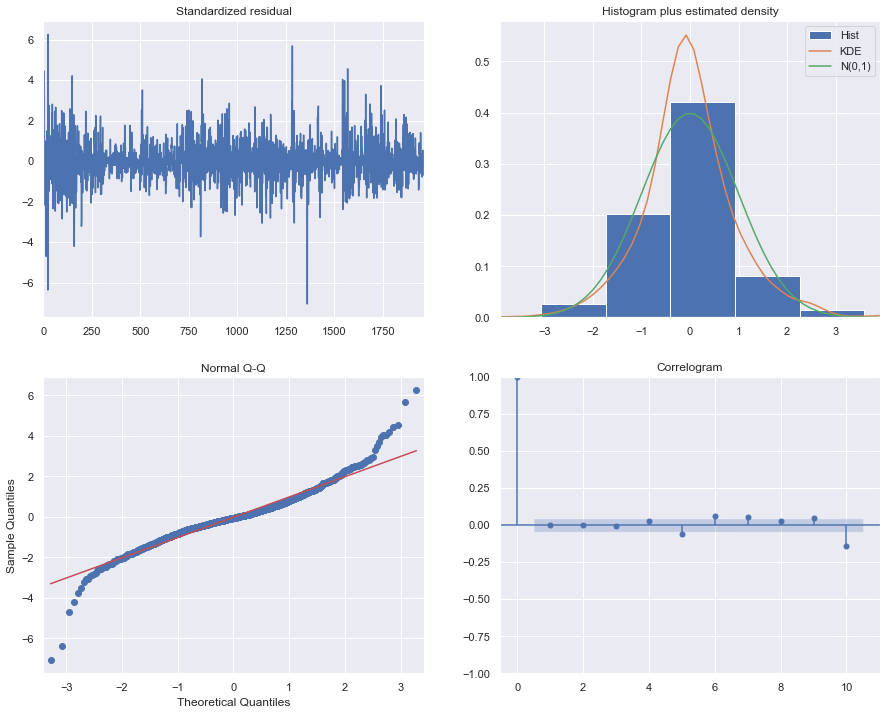

In [15]:
step_wise_exog.plot_diagnostics(figsize=(15,12));

### Fit the SARIMAX model using the best p,d,q orders

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [17]:
model_exog = SARIMAX(train_labels, exog=train_features,
                order=(4,0,0), seasonal_order=(2,1,0,5),
                enforce_invertibility=True, enforce_stationarity=True)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
results = model_exog.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, 0, 5)   Log Likelihood                4221.945
Date:                           Wed, 23 Nov 2022   AIC                          -8395.890
Time:                                   00:33:19   BIC                          -8261.929
Sample:                                        0   HQIC                         -8346.655
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.1241      0.031      3.993      0.000       0.063       0.185
14 DAYS MA         0.1274      0.058      2.200      0.028       0.014       0.241
21 DAYS MA         0.2033      0.053      3.827      0.000       0.099       0.307
7 DAYS STD DEV    -0.0008      0.002     -0.517      0.605      -0.004       0.002
RSI 7              0.1083      0.007     15.944      0.000       0.095       0.122
RSI 14            -0.5006      0.025    -19.682      0.000      -0.550      -0.451
RSI 21             0.6373      0.021     30.971      0.000       0.597       0.678
MFI 7             -0.0006      0.001     -0.463      0.643      -0.003       0.002
MFI 14            -0.0012      0.002     -0.568      0.570      -0.005       0.003
MFI 21            -0.0054      0.002     -2.273      0.023      -0.010      -0.001
dayofweek       2.382e-05      0.001      0.029      0.977      -0.002       0.002
quarter           -0.0106      0.007     -1.501      0.133      -0.024       0.003
month              0.3112      0.371      0.839      0.402      -0.416       1.038
year              -0.3714      0.323     -1.150      0.250      -1.004       0.262
dayofyear         -0.3385      0.374     -0.906      0.365      -1.071       0.394
dayofmonth         0.0232      0.031      0.754      0.451      -0.037       0.084
weekofyear        -0.0010      0.004     -0.229      0.819      -0.010       0.008
ar.L1              0.7816      0.017     47.270      0.000       0.749       0.814
ar.L2              0.0518      0.023      2.226      0.026       0.006       0.097
ar.L3             -0.0046      0.024     -0.194      0.846      -0.052       0.042
ar.L4              0.0104      0.018      0.568      0.570      -0.025       0.046
ar.S.L5           -0.5988      0.016    -38.469      0.000      -0.629      -0.568
ar.S.L10          -0.2316      0.018    -13.074      0.000      -0.266      -0.197
sigma2             0.0008   1.29e-05     60.947      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  61.05   Jarque-Bera (JB):             11878.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [20]:
predictions = results.predict(start=train_len, end=len(df)-1, exog=test_features)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
actual_close = df[['Close']]
act = pd.DataFrame(actual_close.iloc[train_len:, 0])

In [22]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_features.index
predictions['Actual'] = act['Close']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [23]:
predictions

,Pred,Actual
Date,,
2020-09-10,-1.646611,-1.621981
2020-09-11,-1.491058,-1.516806
2020-09-14,-1.481844,-1.510619
2020-09-15,-1.562374,-1.566300
2020-09-16,-1.571753,-1.566300
...,...,...
2022-09-12,-0.134006,1.545664
2022-09-13,-0.103166,1.607532
2022-09-14,-0.180378,1.499263


<AxesSubplot:xlabel='Date'>

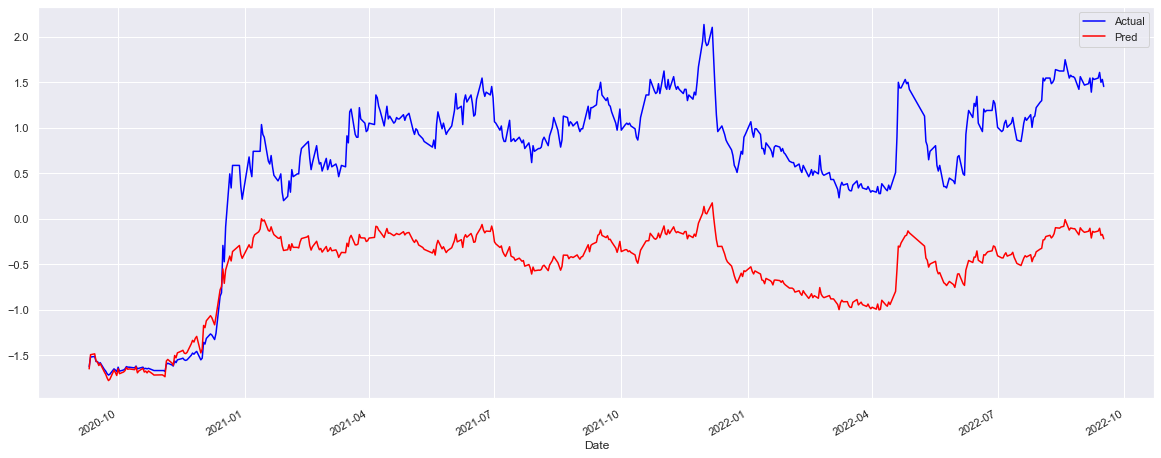

In [24]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Evaluation

In [25]:
from joblib import load

In [26]:
close_scaler = load('../feature_engineering/isat_close_scaler.bin')

In [27]:
inversed_pred = close_scaler.inverse_transform(np.array(predictions['Pred']).reshape(-1,1))
inversed_act = close_scaler.inverse_transform(np.array(predictions['Actual']).reshape(-1,1))

In [28]:
inversed = pd.DataFrame(inversed_pred)
inversed['Actual'] = inversed_act
inversed.rename({0:'Pred'}, axis=1, inplace=True)
inversed.index = test_labels.index
inversed.head(2)

,Pred,Actual
Date,,
2020-09-10,2040.190265,2080.0
2020-09-11,2291.616526,2250.0


**Plot Error Distribution**

In [29]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

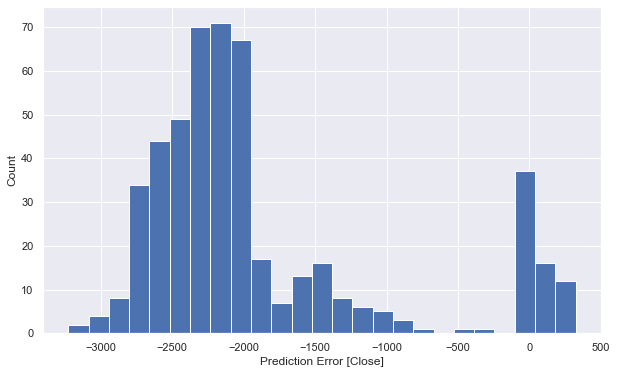

In [31]:
plt.figure(figsize=(10,6))
plotErrorHist(inversed)

**RMSE**

In [32]:
from statsmodels.tools.eval_measures import rmse

In [33]:
rmse(inversed['Pred'], inversed['Actual'])

2073.1999431087293

**MAPE**

In [34]:
# mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [35]:
mape(inversed['Actual'], inversed['Pred'])

30.70448685709699

**R-squared**

In [36]:
from sklearn.metrics import r2_score

In [37]:
r2_score(inversed['Actual'], inversed['Pred'])

-0.8998123311586848

### Save the model

In [38]:
from joblib import dump, load
dump(results, './models/isat.joblib') 

['./models/isat.joblib']

In [39]:
loaded = load('./models/isat.joblib')
loaded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, 0, 5)   Log Likelihood                4221.945
Date:                           Wed, 23 Nov 2022   AIC                          -8395.890
Time:                                   00:34:31   BIC                          -8261.929
Sample:                                        0   HQIC                         -8346.655
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.1241      0.031      3.993      0.000       0.063       0.185
14 DAYS MA         0.1274      0.058      2.200      0.028       0.014       0.241
21 DAYS MA         0.2033      0.053      3.827      0.000       0.099       0.307
7 DAYS STD DEV    -0.0008      0.002     -0.517      0.605      -0.004       0.002
RSI 7              0.1083      0.007     15.944      0.000       0.095       0.122
RSI 14            -0.5006      0.025    -19.682      0.000      -0.550      -0.451
RSI 21             0.6373      0.021     30.971      0.000       0.597       0.678
MFI 7             -0.0006      0.001     -0.463      0.643      -0.003       0.002
MFI 14            -0.0012      0.002     -0.568      0.570      -0.005       0.003
MFI 21            -0.0054      0.002     -2.273      0.023      -0.010      -0.001
dayofweek       2.382e-05      0.001      0.029      0.977      -0.002       0.002
quarter           -0.0106      0.007     -1.501      0.133      -0.024       0.003
month              0.3112      0.371      0.839      0.402      -0.416       1.038
year              -0.3714      0.323     -1.150      0.250      -1.004       0.262
dayofyear         -0.3385      0.374     -0.906      0.365      -1.071       0.394
dayofmonth         0.0232      0.031      0.754      0.451      -0.037       0.084
weekofyear        -0.0010      0.004     -0.229      0.819      -0.010       0.008
ar.L1              0.7816      0.017     47.270      0.000       0.749       0.814
ar.L2              0.0518      0.023      2.226      0.026       0.006       0.097
ar.L3             -0.0046      0.024     -0.194      0.846      -0.052       0.042
ar.L4              0.0104      0.018      0.568      0.570      -0.025       0.046
ar.S.L5           -0.5988      0.016    -38.469      0.000      -0.629      -0.568
ar.S.L10          -0.2316      0.018    -13.074      0.000      -0.266      -0.197
sigma2             0.0008   1.29e-05     60.947      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  61.05   Jarque-Bera (JB):             11878.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""